## Clustering and Topic modelling


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_files
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [2]:
# Get data
random_state = 0 
DATA_DIR = "bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0
1,Halo 2 sells five million copies\n\nMicrosoft ...,4
2,MSPs hear renewed climate warning\n\nClimate c...,2
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3
4,Tories reject rethink on axed MP\n\nSacked MP ...,2


In [3]:
# Prepare data for Clustering
vect = TfidfVectorizer(stop_words="english")
vect.fit(df.text.values)
features = vect.transform(df.text.values)

In [4]:
# Prepare data for Topics
spy = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def only_nouns(texts):
    output = []
    for doc in spy.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output
tp = df
tp['text'] = only_nouns(tp['text'])
tp.head()

,text,label
0,boss award executive business magazine title p...,0
1,copy bumper sale fi shooter game copy sale com...,4
2,climate warning climate change control decade ...,2
3,success week race track bronze injury season i...,3
4,tory rethink association candidate election ag...,2


In [5]:
# KMeans
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=5, random_state=0)

In [6]:
# Get cluster labels for dataset
cls.labels_

array([3, 3, 3, ..., 0, 2, 4], dtype=int32)

In [7]:
# Predict cluster labels 
cls.predict(features)

array([3, 3, 3, ..., 0, 2, 4], dtype=int32)

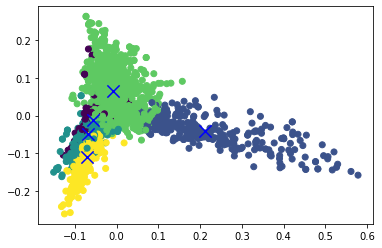

In [8]:
# Reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

### We can see the 5 different cluster

In [9]:
# Evaluation with labelled dataset
homogeneity_score(df.label, cls.predict(features))

0.5433462110559382

In [10]:
# Evaluation with unlabelled dataset
silhouette_score(features, labels=cls.predict(features))

0.009927737289334684

### The scores ranges between 0 and 1 

In [11]:
# Topics 
n_topics = 5

In [12]:
# Vectorize
vect = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vect.fit_transform(tp.text)

In [13]:
# Non Negative Matrix Factorization
nmf = NMF(n_components=n_topics, random_state=random_state)
nmf.fit(features)
nmf_feature_names = vect.get_feature_names()

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [14]:
# Use features_lda (raw term count) features for LDA.
vect_lda = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=5000,
                                stop_words='english')

lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state,max_iter=5,
                                learning_method='online',learning_offset=50.)
features_lda = vect_lda.fit_transform(tp.text)
lda.fit(features_lda)
lda_feature_names = vect_lda.get_feature_names()

In [15]:
# number of most influencing words to display per topic

# business, entertainment, politics, sport, tech

n_top_words = 15
for i, topic_vec in enumerate(lda.components_):
    print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(lda_feature_names[fid], end=' ')
    print()

0 deal club bid offer oil country year debt share budget bank talk aid decision shareholder 
1 people music technology phone user service computer year firm game network site software company way 
2 election people game party government time minister leader plan issue campaign player way year home 
3 film year time award game star number world week injury match director player actor team 
4 year company government firm market month sale economy growth rate country price business share cost 


In [16]:
# Test with your own data
test_articles = [
    "Stock market is on the rise",
    "Half life 3 video game might be coming soon"
]
nmf.transform(vect.transform(test_articles)).argsort(axis=1)[:,-1]

array([0, 1])

In [17]:
# visualize top words for each model
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

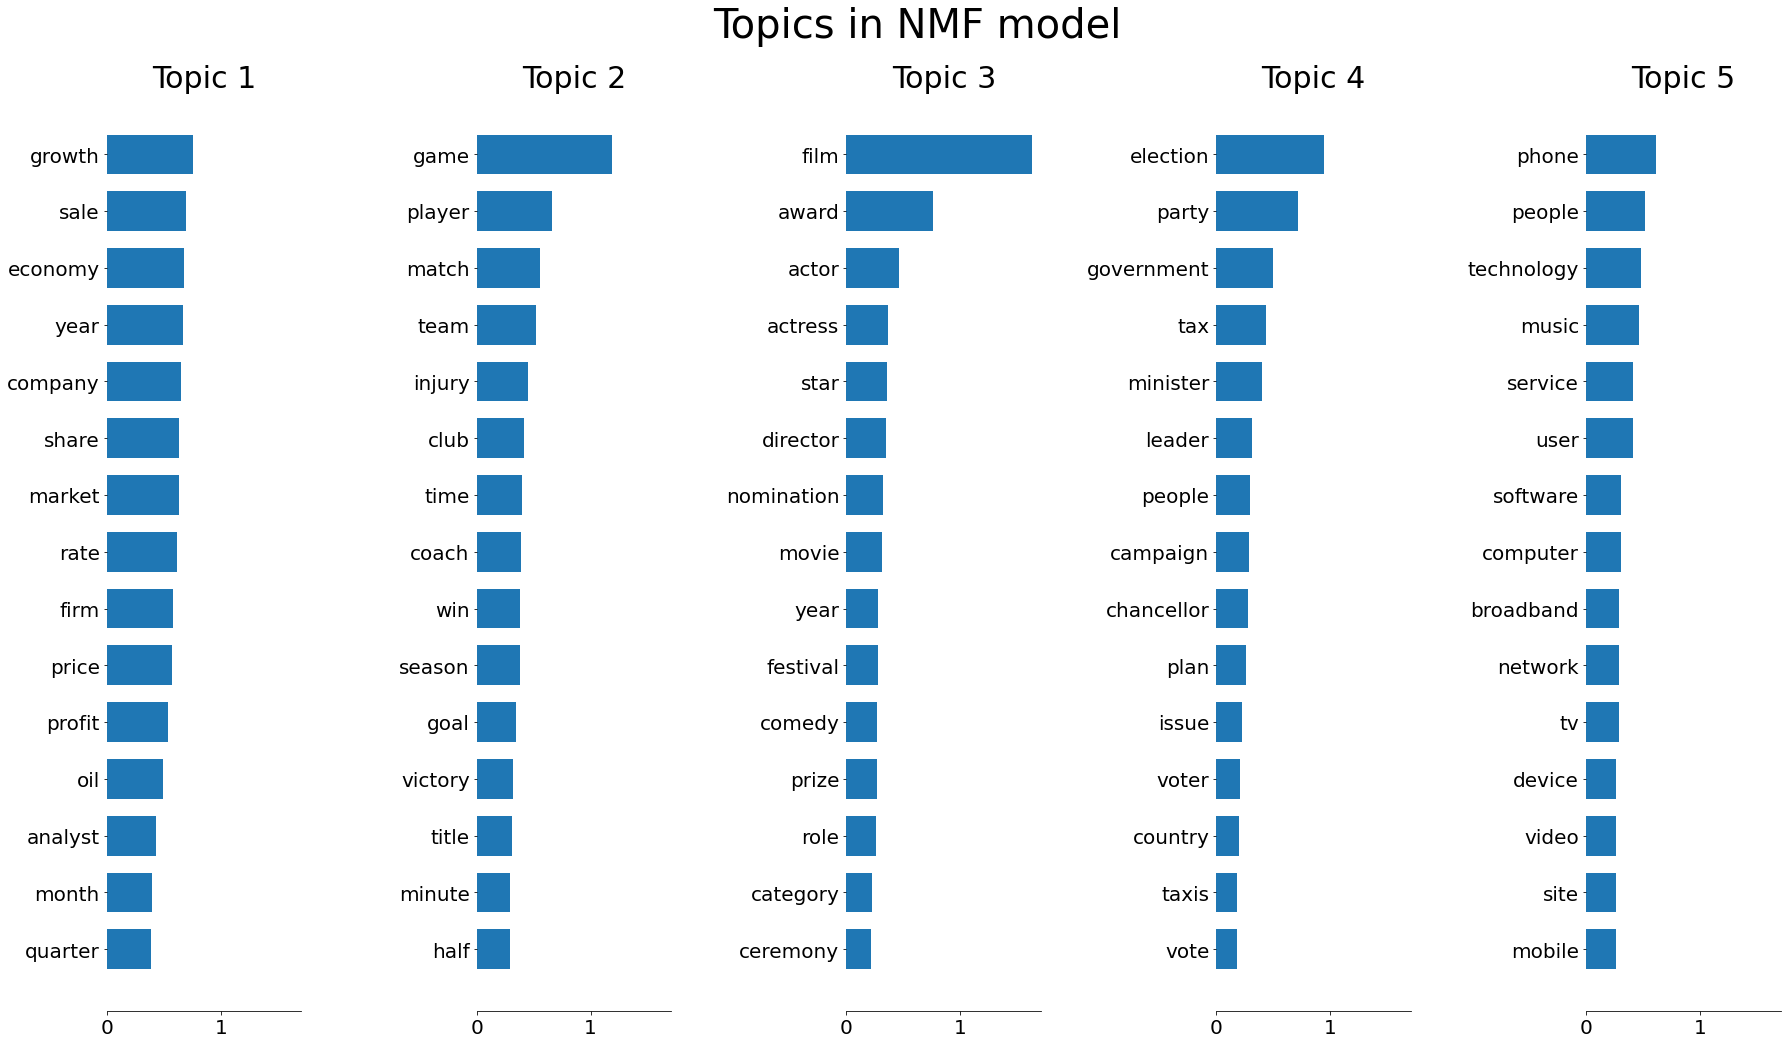

In [18]:
plot_top_words(nmf, nmf_feature_names, n_top_words, 'Topics in NMF model')

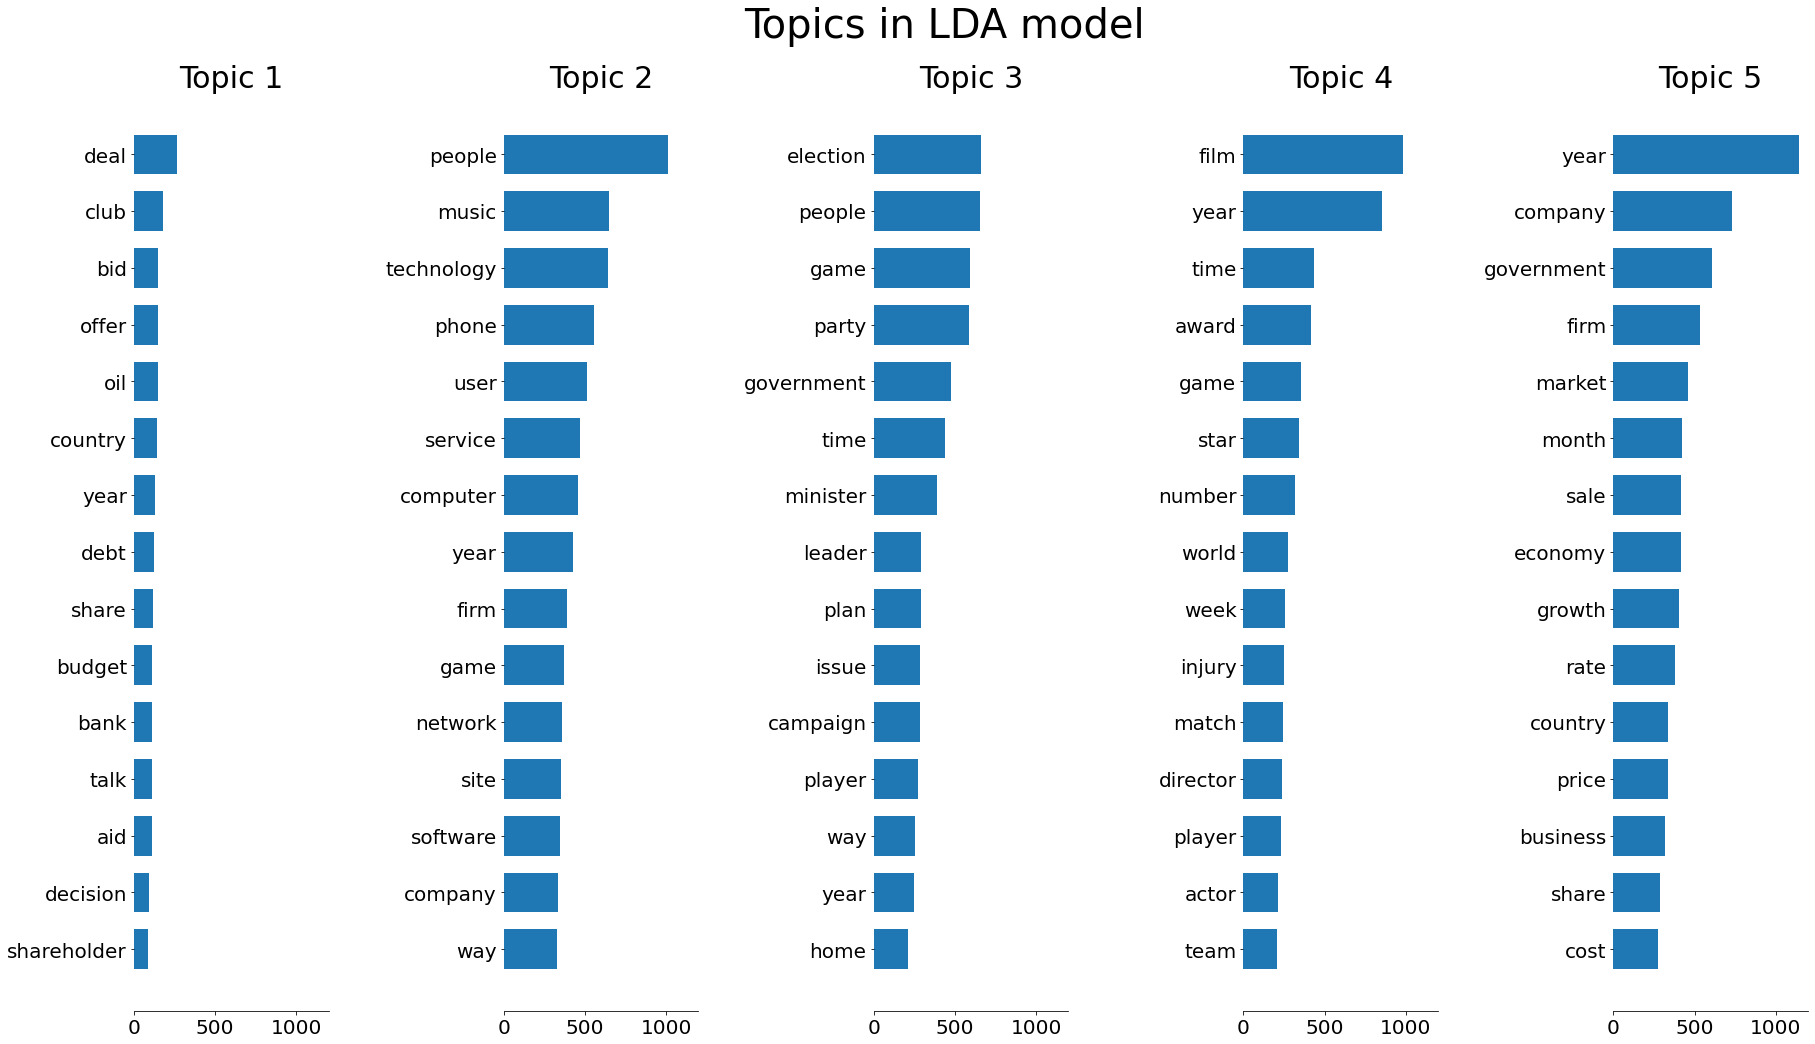

In [19]:
plot_top_words(lda, lda_feature_names, n_top_words, 'Topics in LDA model')

In [20]:
# List the top 15 words
for index, topic in enumerate(lda.components_):
    print(f'Top 15 words for Topic #{index}')
    print([vect_lda.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic #0
['shareholder', 'decision', 'aid', 'talk', 'bank', 'budget', 'share', 'debt', 'year', 'country', 'oil', 'offer', 'bid', 'club', 'deal']


Top 15 words for Topic #1
['way', 'company', 'software', 'site', 'network', 'game', 'firm', 'year', 'computer', 'service', 'user', 'phone', 'technology', 'music', 'people']


Top 15 words for Topic #2
['home', 'year', 'way', 'player', 'campaign', 'issue', 'plan', 'leader', 'minister', 'time', 'government', 'party', 'game', 'people', 'election']


Top 15 words for Topic #3
['team', 'actor', 'player', 'director', 'match', 'injury', 'week', 'world', 'number', 'star', 'game', 'award', 'time', 'year', 'film']


Top 15 words for Topic #4
['cost', 'share', 'business', 'price', 'country', 'rate', 'growth', 'economy', 'sale', 'month', 'market', 'firm', 'government', 'company', 'year']




In [21]:
# Perform test with own data
test_articles = [
    "Stock market is on the rise",
    "Half life 3 video game might be coming soon"
]
tf_test=vect_lda.transform(test_articles[-2:])
print(lda.transform(vect_lda.transform(test_articles[-2:])))

[[0.05115569 0.05029885 0.05000994 0.05000425 0.79853127]
 [0.04008145 0.24766919 0.04089179 0.63117475 0.04018282]]


In [22]:
# model performance using perplexity and log-likelihood
print("Log likelihood: ", lda.score(features_lda))
print("Perplexity: ", lda.perplexity(features_lda))

Log likelihood:  -1195524.728214982
Perplexity:  1059.8815898862213


In [23]:
# Calculate coherence
# Tokenize cleaned up corpus
tp_tokens = [doc.split() for doc in tp.text]

# C_V coherence
metric_coherence_gensim(measure='c_v', 
                        top_n=5, 
                        topic_word_distrib=lda.components_, 
                        dtm=features_lda, 
                        vocab=np.array(lda_feature_names), 
                        texts=tp_tokens)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[0.63543103093058,
 0.6387676628641094,
 0.485906985421209,
 0.4825721604422541,
 0.525439684960724]

In [ ]:
# Grid search to find the best model

# Define Search Parameters
search_params = {'n_components': [2, 3, 4, 5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Initialze the model
lda_grid = LatentDirichletAllocation()

# Initialze Grid Search 
model = GridSearchCV(lda_grid, search_params)

# Get the best model and metrics
model.fit(features_lda)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(features_lda))


In [ ]:
# View details of the grid search
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')
print(df_cv_results)

In [ ]:
# Visualize details of other models 
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)